## 1.2 Dataset

In [1]:
# !pip install glob2

In [2]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
import numpy as np
import sys


# Configurations principales de nos modèles
IMG_SIZE          = 150             # taille coté final d'une image en pixel (ici 28x28)
NB_EPOCHS_DENOISE = 40               # nombre epoch alogithme debruiter
BATCH_SIZE        = 16            # taille batch de traitement
SAVE_MODEL_DENOISE = "denoiser.h5"     # sauvegarde du modele de debruitage

def process(image):
    image = tf.cast(image/255. ,tf.float32)
    return image


# Import du .env
import dotenv
import os

# Chargement du .env !!!!!!!!!!!! CHANGER LE PATH !!!!!!!!!!!!!!
# Renvoie true si le .env est chargé
dotenv.load_dotenv('/home/cesi/datascience/.env.local')

models_path = os.environ.get('MODELS_PATH_LIVRABLE2')
sys.path.insert(0, models_path)

import builder_vae
import homemade
import test2
import resnet
import test3


SAVE_WEIGHTS_PATH = os.environ.get('WEIGHT_PATH_LIVRABLE2')
SOURCE_LIVRABLE2_PATH = os.getenv("SOURCE_LIVRABLE2_PATH")

2023-10-17 12:59:32.156851: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-17 12:59:32.156925: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-17 12:59:32.156957: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-17 12:59:32.164331: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:

x_train, x_test = image_dataset_from_directory(
    SOURCE_LIVRABLE2_PATH,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    # label_mode=None,
    shuffle=False,
    validation_split=0.2,
    subset="both",
    seed=123,
    color_mode="rgb"
)

AUTOTUNE = tf.data.experimental.AUTOTUNE

x_train = x_train.map(lambda x,y: (x/255,y))
x_test = x_test.map(lambda x,y: (x/255,y))

Found 9993 files belonging to 1 classes.
Using 7995 files for training.
Using 1998 files for validation.


2023-10-17 13:01:16.936774: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-17 13:01:16.941269: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-17 13:01:16.941316: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-17 13:01:16.942051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-17 13:01:16.942107: I tensorflow/compile

In [4]:
%ls ./photoOnly/Photo

ls: cannot access './photoOnly/Photo': No such file or directory


Commençons par écrire une fonction qui permet de visualiser $n$ premiers enregistrements en noir et blanc. 

In [5]:
import matplotlib.pyplot as plt
from random import uniform
import tensorflow as tf
# os.chdir(r'/tf')
from keras_cv.layers import RandomGaussianBlur

def add_noise(img, perturbation_conf):
    pertubation = perturbation_conf['perturbation']
    noised_img = img
    if pertubation == 1:
        blur_kernel_value = perturbation_conf['blur_kernel_size']
        noised_img = RandomGaussianBlur(kernel_size=blur_kernel_value, factor=(0.5, 3))(noised_img)
    elif pertubation == 2:
        noise_value = perturbation_conf['noise_factor']
        noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=noise_value/255, dtype=tf.float32)
        noised_img = tf.cast(img, tf.float32) + noise
    elif pertubation == 3:
        noise_value = perturbation_conf['noise_factor']
        blur_kernel_value = perturbation_conf['blur_kernel_size']
        noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=noise_value/255, dtype=tf.float32)
        noised_img = tf.cast(img, tf.float32) + noise
        noised_img = RandomGaussianBlur(kernel_size=blur_kernel_value, factor=(0.5, 1))(noised_img)
    else:
        noised_img = img
        
    return noised_img, img


noise_configuration = {
    0:{
    'perturbation': 1,
    'blur_kernel_size': 6,
    },
    1:{
    'perturbation': 2,
    'noise_factor': 20
    },
    2:{
    'perturbation': 3,
    'noise_factor': 12,
    'blur_kernel_size': 2
    },
    3:{
    'perturbation': 0
    }
}

x_train_noisy = x_train.map(lambda x,y: (add_noise(x, noise_configuration[1])))
x_test_noisy = x_test.map(lambda x,y: (add_noise(x, noise_configuration[1])))

x_train_blur = x_train.map(lambda x,y: (add_noise(x, noise_configuration[0])))
x_test_blur = x_test.map(lambda x,y: (add_noise(x, noise_configuration[0])))

x_train_noise_blur = x_train.map(lambda x,y: (add_noise(x, noise_configuration[2])))
x_test_noise_blur = x_test.map(lambda x,y: (add_noise(x, noise_configuration[2])))

x_train_clean = x_train.map(lambda x,y: (add_noise(x, noise_configuration[3])))
x_test_clean = x_test.map(lambda x,y: (add_noise(x, noise_configuration[3])))

random_train_set = x_train_clean.concatenate(x_train_noisy).concatenate(x_train_blur).concatenate(x_train_noise_blur)
random_test_set = x_test_clean.concatenate(x_test_noisy).concatenate(x_test_blur).concatenate(x_test_noise_blur)
#shuffle the dataset
# random_train_set = random_train_set.shuffle(1000)
# random_test_set = random_test_set.shuffle(1000)


# display three images on a single row with matplotlib 
def display_images(*images):
    """Display images on a single row."""
    plt.figure(figsize=(50, 50))
    for index, image in enumerate(images):
        plt.subplot(1, len(images), index+1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

    # plt.figure(figsize=(15, 15))
    # ax = plt.subplot(1, 3, 1)
    # plt.imshow(left)
    # plt.gray()
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)
    # ax = plt.subplot(1, 3, 2)
    # plt.imshow(middle)
    # plt.gray()
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)
    # if right is None:
    #     return
    # ax = plt.subplot(1, 3, 3)
    # plt.imshow(right)
    # plt.gray()
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)

Using TensorFlow backend


In [6]:
# display the same image from x_train and x_train_noisy and x_train_blur and x_train_noise_blur
# for image, label in x_train.take(1):
#     sample_image = image[0]
#     sample_label = label
# for image, label in x_train_noisy.take(1):
#     sample_image_noisy = image[0]
#     sample_label_noisy = label
# for image, label in x_train_blur.take(1):
#     sample_image_blur = image[0]
#     sample_label_blur = label
# for image, label in x_train_noise_blur.take(1):
#     sample_image_noise_blur = image[0]
#     sample_label_noise_blur = label
# display_images(np.squeeze(sample_image), np.squeeze(sample_image_noisy), np.squeeze(sample_image_blur), np.squeeze(sample_image_noise_blur))

Voyons ce que ça donne :

# AutoEncoder

In [7]:
MODEL_CHOSEN = 'test2'

def load_model(model_choosen):
    match(model_choosen):
        case 'homemade':
            model = homemade.build(IMG_SIZE)
        case 'vae':
            model = builder_vae.build(IMG_SIZE, 64)
        case 'test2':
            model = test2.build(IMG_SIZE)
        case 'test3':
            model = test3.build(IMG_SIZE)
        case 'resnet':
            model = resnet.build(IMG_SIZE)
    return model
autoencoder = load_model(MODEL_CHOSEN)
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 150, 150, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 150, 150, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 150, 150, 64)         0         ['conv2d_1[0][0]']            
                                                                                              

### Entrainement de l'auto-encodeur

On va ensuite entraîner l'auto-encodeur en utilisant les constantes définit au début (`NB_EPOCHS_DENOISE,BATCH_SIZE`)

In [8]:
print(len(random_train_set))


2000


In [9]:
# path = createTrainingData.create_training_data(weight_path, model, model_choosen, num_classes, image_h, image_w, batch_size)

# checkpoint_path = path+"/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# weights_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_path,
#     verbose=1,
#     save_weights_only=True,
#     save_freq='epoch')

# history = model.fit(train_set, epochs=epochs, validation_data=test_set, callbacks=[weights_callback])

history = autoencoder.fit(
    random_train_set,
    epochs=3,
    shuffle=True,
    validation_data=random_test_set
)

Epoch 1/3


2023-10-17 13:01:26.200088: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-10-17 13:01:27.057001: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-10-17 13:01:33.946667: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa8b6c19da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-17 13:01:33.946734: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro P4000, Compute Capability 6.1
2023-10-17 13:01:33.952109: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-17 13:01:34.043702: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster usi

2000/2000 [==============================] - 1463s 723ms/step - loss: 0.0030 - accuracy: 0.7990 - val_loss: 0.0045 - val_accuracy: 0.7905
Epoch 2/3
2000/2000 [==============================] - 1485s 742ms/step - loss: 0.0019 - accuracy: 0.8164 - val_loss: 0.0042 - val_accuracy: 0.7963
Epoch 3/3
2000/2000 [==============================] - 1491s 745ms/step - loss: 0.0017 - accuracy: 0.8186 - val_loss: 0.0043 - val_accuracy: 0.8025


Affichez maintenant la courbe d'apprentissage. Que pensez-vous des performances du modèle ?

In [ ]:
epochs_range = range()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.savefig(path+"/metrics.png")

plt.show()

In [10]:
model_weight_path = SAVE_WEIGHTS_PATH + 'test2/weights_all_noise_150px.h5' 

In [11]:
autoencoder.save_weights(model_weight_path)

In [ ]:
autoencoder.load_weights(model_weight_path)

In [ ]:
pred = autoencoder.predict(x_test_noisy)    

In [ ]:
image_index = 1
batch_index = 1
load_test_data_noised(1)
original_image = list(x_test.take(batch_index).as_numpy_iterator())[0][0][image_index]
noisy_image = list(x_test_noisy.take(batch_index).as_numpy_iterator())[0][0][image_index]
denoised_image = pred[image_index]


display_three_images(original_image, noisy_image, denoised_image)

In [ ]:
loss, accuracy = autoencoder.evaluate(random_test_set)

In [28]:
test_sets = {
    'noisy': x_test_noisy,
    'blur': x_test_blur,
    'noise_blur': x_test_noise_blur,
    'clean': x_test_clean,
    'overall': random_test_set
}
results = {}
accuracy = {}
loss = {}
for test_set_name in test_sets:
    loss[test_set_name], accuracy[test_set_name] = autoencoder.evaluate(test_sets[test_set_name])

500/500 [==============================] - 83s 165ms/step - loss: 0.0043 - accuracy: 0.8026


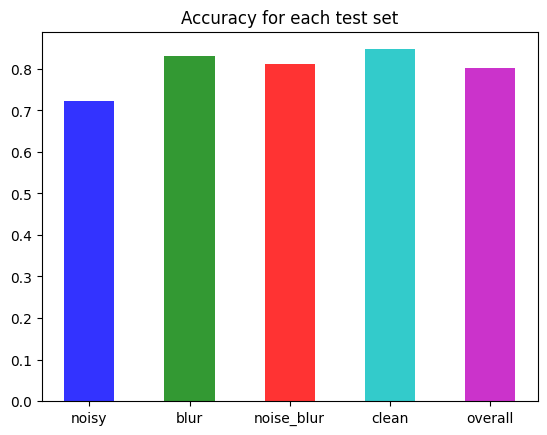

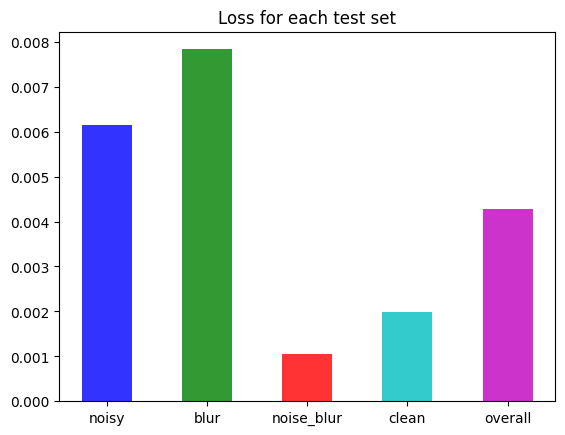

In [33]:
# plot the accuracy for each test set in different color for each bar in the accuracy dictionary
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
bars = plt.bar(range(len(accuracy)), list(accuracy.values()), align='center', color=colors, alpha=0.8, width=0.5)
plt.xticks(range(len(accuracy)), list(accuracy.keys()))
# for bar, acc in zip(bars, accuracy):
#     plt.text(bar.get_x() + bar.get_width() / 2, accuracy[acc], f'{accuracy[acc]:.2f}', ha='center', va='bottom')
print("arrête de rire")
print("caca boudin")

plt.title('Accuracy for each test set')
# plt.savefig(path+"/accuracy.png")
plt.show()

plt.bar(range(len(loss)), list(loss.values()), align='center', color=colors, alpha=0.8, width=0.5)
plt.xticks(range(len(loss)), list(loss.keys()))
# for bar, key in zip(bars, loss):
#     plt.text(bar.get_x() + bar.get_width() / 2, loss[key], f'{loss[key]:.2f}', ha='center', va='bottom')
plt.title('Loss for each test set')
# plt.savefig(path+"/accuracy.png")
plt.show()















In [ ]:
p = autoencoder.predict(list(x_test.take(1).as_numpy_iterator())[0][0][3:][0].reshape(1,224,224,3))

display_images(list(x_test.take(1).as_numpy_iterator())[0][0][3:], n=1)
display_images(p, n=1)

In [ ]:
# Visualisation des pertes d'apprentissage (Train) et de validation (Test)
plt.plot( #A COMPLETER
         label='train')
plt.plot( #A COMPLETER
         label='test')
plt.legend()

Que pensez-vous des performances du modèle ?
<em>À COMPLÉTER</em>


# 1.4 Sauvgarde de l'auto-encodeur

L'entrainement de l'auto-encodeur sans utilisation de puissance de calcul (GPU) peut prendre beaucoup de temps. Usuellement, nous sauvegardons le modèle entraîné en local ou sur un serveur distant pour l'utiliser ultérieurement afin de traiter les nouvelles données (d'ailleurs, vous verrez une utilisation avancée de cette technique, le transfert learning, dès la semaine prochaine).
Pour sauvegarder le modèle `autoencoder`, utiliser la méthode `save`.

In [ ]:
# save the model
#A COMPLETER


In [ ]:
decoded_imgs = #A COMPLETER
